In [81]:
import pandas as pd
import json
from glob import glob
import os.path as osp
import datetime
import wordcloud
from io import StringIO
import stop_words
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import re

In [82]:
pd.set_option('display.max_colwidth', 255)

In [104]:
subjects = []
for media in ['France 3', 'France 2', 'TF1']:
    for year in ['2022']:
        for month in ['10', '11']:
            month_path = f'../data-news-json/media={media}/year={year}/month={month}'
            day_files = glob(f'{month_path}/day=*/*.json')
            for day_file in day_files:
                for line in open(day_file):
                    subject = json.loads(line)
                    subject['media'] = media.lower().replace(' ', '')
                    subjects.append(subject)

In [105]:
data = pd.DataFrame(subjects)

In [106]:
focus_media = "france2"
edition = "20h"
weeks_ago = 0

In [107]:
today = datetime.date.today()
weekday = today.weekday()
start_delta = datetime.timedelta(days=weekday, weeks=weeks_ago)

In [108]:
last_week_start = today - start_delta

In [109]:
last_week_end = last_week_start + datetime.timedelta(days=7)

In [110]:
last_week_start, last_week_end

(datetime.date(2022, 11, 14), datetime.date(2022, 11, 21))

In [111]:
last_week = data[(data.media == focus_media)
                 & (data["date"] >= last_week_start.strftime("%Y-%m-%d")) 
                 & (data["date"] < last_week_end.strftime("%Y-%m-%d")) ].copy()

In [112]:
last_week.url

1898                   https://www.francetvinfo.fr/monde/usa/geopolitique-une-rencontre-importante-entre-les-presidents-des-etats-unis-et-de-la-chine_5477145.html
1899                                         https://www.francetvinfo.fr/france/chasse/chasse-une-application-pour-connaitre-le-parcours-de-la-battue_5476695.html
1900                    https://www.francetvinfo.fr/monde/europe/manifestations-en-ukraine/guerre-en-ukraine-volodymyr-zelenski-s-est-rendu-a-kherson_5476683.html
1901                         https://www.francetvinfo.fr/les-jeux-olympiques/paris-2024/jeux-olympiques-2024-les-mascottes-un-symbole-franco-francais_5476731.html
1902                                  https://www.francetvinfo.fr/replay-jt/france-2/20-heures/cambriolages-les-badges-d-immeuble-au-c-ur-d-un-trafic_5477154.html
                                                                                   ...                                                                            
2027                  

In [113]:
import re
if focus_media == 'tf1':
    topic_pattern = re.compile("https://www.tf1info.fr/(\S+)/(\S+).html")
    last_week['topic'] = [topic_pattern.match(u).group(1) for u in last_week.url]
    
if focus_media == 'france2':
    topic_pattern = re.compile("https://www.francetvinfo.fr/(\S+)/(\S+).html")
    last_week['topic'] = [topic_pattern.match(u).group(1).split('/')[0] 
                              for u in [x.replace('https://www.francetvinfo.frhttps://www.francetvinfo.fr', 'https://www.francetvinfo.fr') for x in last_week.url]]

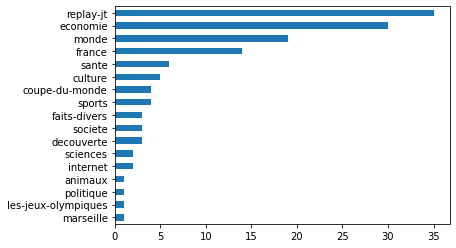

In [114]:
last_week['topic'].value_counts().plot(kind='barh').invert_yaxis()

In [115]:
last_week.columns

Index(['title', 'description', 'date', 'order', 'presenter', 'authors',
       'editor', 'editorDeputy', 'url', 'urlTvNews',
       'containsWordGlobalWarming', 'media', 'topic'],
      dtype='object')

In [116]:
if focus_media == 'france2':
    last_week['formatted_date'] = [d.strftime('%d %B, %A') for d in pd.to_datetime(last_week.date)]  
if focus_media == 'tf1':
    last_week['formatted_date'] = [(d - datetime.timedelta(hours=20)+datetime.timedelta(minutes=1)).strftime('%d %B, %A') for d in pd.to_datetime(last_week.date)]

In [117]:
if focus_media == 'france2' and edition == "20h":
    last_week_edition = last_week[['20h' in x for x in last_week.urlTvNews]].copy()
if focus_media == 'france2' and edition == "13h":
    last_week_edition = last_week[['13h' in x for x in last_week.urlTvNews]].copy()
if focus_media == 'tf1' and edition == "20h":
    last_week_edition = last_week[[('20h' in x) or ('we' in x and d[11:13] >= "20") for x,d in zip(last_week.urlTvNews, last_week.date)]].copy()

In [118]:
if focus_media == 'tf1':
    last_week_edition['id'] = [x.split('-')[-1][:-5] for x in last_week_edition.url]
    last_week_edition['order'] = last_week_edition['date']
    if last_week_edition.formatted_date.nunique() == 1:
        order_by_id = last_week_edition.set_index('id').order.rank(method='first').reset_index().set_index('id').order 
    else:
        order_by_id = last_week_edition.groupby('formatted_date').apply(lambda x: x.set_index('id').order.rank(method='first')).reset_index().set_index('id').order    
    last_week_edition['order'] = [order_by_id[x] for x in last_week_edition.id]

In [119]:
if False:
    last_week_edition = last_week[['we' in x for x in last_week.urlTvNews]].copy()
    last_week_edition['id'] = [x.split('-')[-1][:-5] for x in last_week_edition.url]
    last_week_edition['order'] = last_week_20h['id']
    order_by_id = last_week_edition.last_week_edition('formatted_date').apply(lambda x: x.set_index('id').order.rank(method='first')).reset_index().set_index('id').order    
    last_week_edition['order'] = [order_by_id[x] for x in last_week_edition.id]

In [120]:
conducteur = last_week_edition.pivot(index='order', columns='formatted_date', values='title')

In [121]:
last_week_edition.formatted_date.value_counts().sort_index()

14 November, Monday       12
15 November, Tuesday      13
16 November, Wednesday    14
17 November, Thursday     12
18 November, Friday       12
Name: formatted_date, dtype: int64

In [122]:
conducteur

formatted_date,"14 November, Monday","15 November, Tuesday","16 November, Wednesday","17 November, Thursday","18 November, Friday"
order,,,,,
1,Afghanistan : les talibans demandent la stricte application de la charia,Carburants : les Français profitent des dernières heures avant la baisse de la ristourne,Missile tombé en Pologne : 24 heures sous haute tension,Mayotte : l'île en proie à une flambée de violence,Chine : les habitants excédés par la politique stricte du zéro-Covid
2,Carburants : 21 % des stations-service en pénurie avant la baisse des aides,Prix des carburants : à quoi faut-il s'attendre pour l'année 2023 ?,Missile tombé en Pologne : une frappe ukrainienne est-elle en cause ?,Marne : le village de Suippes secoué par des vents violents,Justice : 123 migrants de l’Ocean Viking remis en liberté
3,Tourisme : la fin des billets d’avion pas chers,Bas-Rhin : le choc après l'annonce de la fermeture d’une usine Heineken historique,Missile tombé en Pologne : Varsovie en état d'alerte ?,Pouvoir d’achat : le budget des ménages grignoté par les dépenses contraintes,Accident de Millas : la conductrice du bus condamnée à un an de prison ferme
4,Chômage : vers une baisse des droits dès 2023 ?,Réforme des retraites : vers la fin des régimes spéciaux ?,Effondrement d’immeubles : des fragilités et des négligences,Chauffage : les ramoneurs débordés par la demande,SNCF : quels billets sont concernés par la hausse des prix ?
5,"VIDEO. Santé : trois questions sur la grève des laboratoires d'analyses, qui dure jusqu'à mercredi",Consommation : un bonus pour encourager à la réparation de l’électroménager,"Crise énergétique : les résultats encourageants d'Enedis, qui a coupé les ballons d’eau chaude le midi",Royaume-Uni : des vols de nourriture de plus en plus fréquents dans les supermarchés,"Coupe du monde 2022 : la Fifa interdit la vente d’alcool, un revirement soudain"
6,Lille : la sécurité des immeubles de la ville en question,Allemagne : les attaques à la dynamite contre les distributeurs de billets se multiplient,Bois : un trafic très lucratif entre la France et la Chine ?,Transports : des communes rendent le bus gratuit en faveur de l’environnement,Tesla : les États-Unis enquêtent sur le système d’assistance à la conduite de la marque d’Elon Musk
7,"Guerre en Ukraine : après huit mois d'occupation russe, le temps des investigations à Kherson",Guerre en Ukraine : la violente riposte de Vladimir Poutine après la libération de Kherson,Route du Rhum 2022 : ce que l'on sait du drame qui a coûté la vie à deux personnes,Évreux : appel à témoins pour retrouver la cycliste disparue,"Floride : malgré les ouragans, les habitants veulent rester vivre sur les côtes"
8,Géopolitique : une rencontre importante entre les présidents des États-Unis et de la Chine,"Guerre en Ukraine : la Crimée, prochaine bataille d'envergure entre Kiev et Moscou ?",Meurtre de Lola : une marche organisée dans le 19e arrondissement de Paris pour lui rendre hommage,Escroquerie : 14 personnes interpellées dans une arnaque au compte professionnel de formation,Consommation : les Français toujours plus adeptes des abonnements
9,Cambriolages : les badges d'immeuble au cœur d'un trafic,Inde : un géant démographique qui doit faire face à sa consommation d’énergie,Accidents de chasse : les armes sont-elles devenues plus dangereuses ?,Récoltes : des drones cueilleurs mis au point à Tel Aviv,Un jour en France : la pénurie d’amoxicilline pourrait durer jusqu’à mars prochain


In [123]:
query  = "climat"
last_week_edition[last_week_edition.description.apply(lambda x : query in x.lower())][['date', 'media', 'title', 'url']]

,date,media,title,url
1950,2022-11-15T00:00:00.000Z,france2,Coupe du monde du Qatar 2022 : une compétition hautement contestée sur le plan écologique,https://www.francetvinfo.fr/coupe-du-monde/coupe-du-monde-du-qatar-2022-une-competition-contestee-sur-le-plan-ecologique_5479113.html
2002,2022-11-17T00:00:00.000Z,france2,Mayotte : l'île en proie à une flambée de violence,https://www.francetvinfo.fr/france/mayotte/mayotte-l-ile-en-proie-a-une-flambee-de-violence_5483286.html
2029,2022-11-18T00:00:00.000Z,france2,"Floride : malgré les ouragans, les habitants veulent rester vivre sur les côtes",https://www.francetvinfo.fr/monde/environnement/crise-climatique/floride-malgre-les-ouragans-les-habitants-veulent-rester-vivre-sur-les-cotes_5485470.html


In [124]:
print(last_week_edition[last_week_edition.description.apply(lambda x : query in x.lower())]['description'].iloc[0])

À l’heure de l’urgence climatique, la coupe du monde du Qatar 2022, qui débute dimanche 20 novembre, fait figure d’aberration écologique. En effet, les stades ont été climatisés pour pouvoir accueillir l’événement.La coupe du monde de football, qui va se dérouler au Qatar à partir du 20 novembre, soulève de nombreuses interrogations, notamment dans le domaine de l’écologie. Le stade 974 fait figure de vitrine pour le pays, puisqu’il a été entièrement construit à partir de conteneurs et de matériaux recyclés. À l’issue de la compétition, toute la structure sera démontée. Il est également l’unique stade sans climatisation intérieur. Face à la controverse que suscite la climatisation dans les autres stades, le pays organisateur se défend en affirmant utiliser l’énergie solaire pour climatiser. La climatisation dans les stades sous le feu des critiques Si les Qataris se défendent sur le plan écologique, pour les associations de protection de l’environnement, le système de climatisation dan